<a href="https://colab.research.google.com/github/dr-song-summer-project/AI/blob/main/Clustering/K_Means_NLP_k_%EC%B0%BE%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**https://techblog-history-younghunjo1.tistory.com/114**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clustering_num = 15
similarity_cmp = 'reviewRate'

In [ ]:
# 학습용 데이터셋 불러오기
import pandas as pd
document_df = pd.read_excel('/content/drive/My Drive/닥터송 여름 프로젝트/4. 대-스타 해결 2/DRSONG_AI_Project/AI/전처리/data/unlabeled_data_prepro_keyword.xlsx')
# document_df.head()

document_df.drop(['Unnamed: 0', 'encodedSenderId', 'encodedTargetId', 'DateTime'], axis=1, inplace=True)
document_df.head()

,reviewIndex,reviewContent,reviewRate,reviewType
0,0,시간 곧 다 일 불만족 신 부분 나름 조율 다른 조건 조율 과정 없이 바로 워킹맘 ...,1,recruitReview
1,1,자신감 아기 거 좋다 것 같다 파이팅,3,recruitReview
2,2,아이 의의 산 표현 확실하다 아이 터 좋아하다 어머님께 아쉽다,3,recruitReview
3,3,사정 있다 아쉽다 함께,3,recruitReview
4,4,전화 인터뷰 때 저희 집 오신 첫날 정기 좋다 사 전 말 이사 곳도 수 있다 이 동...,1,recruitReview


In [ ]:
# 텍스트 단어들의 어근 원형을 추출하기 위해 함수 생성
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
# string.puncutaion에 문자열의 모든 구두점이 들어있음
# 이를 활용해서 Tokenize시킬 때 구두점들을 제외하기 위한 것
# ord('문자열') => 문자열의 ASCII코드를 반환해줌!
# dict(key, value)형태로 모든 구두점의 각 ASCII코드를 key값으로 넣어주자!
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 토큰화한 각 단어들의 원형들을 리스트로 담아서 반환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]
# 텍스트를 Input으로 넣어서 토큰화시키고 토큰화된 단어들의 원형들을 리스트로 담아 반환
def LemNormalize(text):
    # .translate인자에 구두점 dict넣어주어서 구두점 삭제해준 상태로 토큰화시키기!
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

# Tf-idf 벡터화시키면서 cusotmized해준 토큰화+어근추출 방식 tokenizer인자에 넣어주기
# 벡터화시킬 Tf-idf 도구 옵션 추가해서 구축
# 1,2gram적용, 빈도수 0.05이하, 0.85이상의 빈도수 단어들 제거
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize,
                            stop_words='english', ngram_range=(1,2),
                            min_df=0.05, max_df=0.85)
# fit_transform으로 위에서 구축한 도구로 텍스트 벡터화
# ftr_vect = tfidf_vect.fit_transform(document_df['reviewContent'])
ftr_vect = tfidf_vect.fit_transform(document_df['reviewContent'].values.astype('U'))
print(ftr_vect.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(13283, 39)


In [ ]:
# K-means로 clustering_num개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=clustering_num, max_iter=10000, random_state=42)
# 비지도 학습이니 feature로만 학습시키고 예측
cluster_label = kmeans.fit_predict(ftr_vect)

print(cluster_label)

# 군집화한 레이블값들을 document_df 에 추가하기
document_df['cluster_label'] = cluster_label
print(document_df.sort_values(by=['cluster_label']))
# document_df['reviewType'] = document_df['reviewType'].replace(['recruitReview', 'interviewReview', 'failureReview'],[0, 1, 2])

[2 6 9 ... 5 3 8]
       reviewIndex  ... cluster_label
8097          8097  ...             0
5017          5017  ...             0
5021          5021  ...             0
7085          7085  ...             0
5037          5037  ...             0
...            ...  ...           ...
6277          6277  ...            14
12115        12115  ...            14
11445        11445  ...            14
11444        11444  ...            14
5691          5691  ...            14

[13283 rows x 5 columns]


In [ ]:
document_df.to_excel('clustering_result.xlsx', header=True, index=False)

Text(0.5, 1.0, 'clustering result')

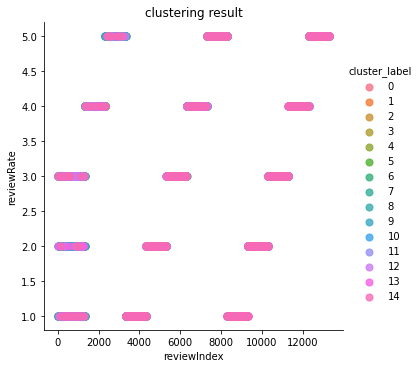

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

sb.lmplot(x='reviewIndex', y='reviewRate', data=document_df, height=5, fit_reg=False, scatter_kws={"s":50}, hue = 'cluster_label')

plt.title('clustering result')

In [ ]:
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['cluster_label']==cluster_num][similarity_cmp]
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
    
    return cluster_details

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['filenames'][:10]}")
        print('-'*20)

feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=kmeans,
                                     cluster_data=document_df,
                                     feature_names=feature_names,
                                     cluster_num=clustering_num,
                                     top_n_features=10)
print_cluster_details(cluster_details)

#####Cluster Num: 0

상위 10개 feature단어들:
 ['전화', '인터뷰', '문자', '연락', '친절하다', '채용', '후', '안', '시간', '없다']

Cluster 0으로 분류된 문서들:
[1, 1, 1, 1, 1, 1, 1, 1, 3, 3]
--------------------
#####Cluster Num: 1

상위 10개 feature단어들:
 ['기회', '다음', '다음 기회', '연락', '좋다', '아쉽다', '채용', '함께', '시간', '있다']

Cluster 1으로 분류된 문서들:
[3, 3, 1, 1, 3, 3, 3, 3, 3, 3]
--------------------
#####Cluster Num: 2

상위 10개 feature단어들:
 ['시간', '약속', '좋다', '연락', '친절하다', '있다', '문자', '제', '터', '함께']

Cluster 2으로 분류된 문서들:
[1, 1, 2, 2, 3, 3, 1, 2, 1, 1]
--------------------
#####Cluster Num: 3

상위 10개 feature단어들:
 ['인연', '좋다', '아쉽다', '다음', '연락', '시간', '터', '아이', '안', '다른']

Cluster 3으로 분류된 문서들:
[3, 3, 3, 3, 3, 3, 3, 1, 3, 1]
--------------------
#####Cluster Num: 4

상위 10개 feature단어들:
 ['있다', '것', '인터뷰', '같다', '터', '친절하다', '제', '것 같다', '문자', '좋다']

Cluster 4으로 분류된 문서들:
[1, 1, 1, 1, 3, 1, 3, 3, 3, 1]
--------------------
#####Cluster Num: 5

상위 10개 feature단어들:
 ['너무', '아이', '좋다', '친절하다', '시간', '아쉽다', '있다', '제', '같다', '것']

Cluster 5으

In [ ]:
# 클러스터링된 문서들 중에서 특정 문서를 하나 선택한 후 비슷한 문서 추출
from sklearn.metrics.pairwise import cosine_similarity
random_int = 1
hotel_idx = document_df[document_df['cluster_label']==6].index
print("호텔 카테고리로 클러스터링된 문서들의 인덱스:\n",hotel_idx)
print("내용 : ", document_df[document_df['reviewIndex']==hotel_idx[random_int]].reviewContent)
# 호텔 카테고리로 클러스터링 된 문서들의 인덱스 중 하나 선택해 비교 기준으로 삼을 문서 선정
comparison_doc = document_df.iloc[hotel_idx[random_int]][similarity_cmp]
print("##유사도 비교 기준 문서 이름:",comparison_doc,'##')
print()

# 위에서 추출한 호텔 카테고리로 클러스터링된 문서들의 인덱스 중 0번인덱스(비교기준문서)제외한
# 다른 문서들과의 유사도 측정
similarity = cosine_similarity(ftr_vect[hotel_idx[random_int]], ftr_vect[hotel_idx])
# print(similarity)

호텔 카테고리로 클러스터링된 문서들의 인덱스:
 Int64Index([    1,     8,    18,    24,    28,    30,    43,    59,    63,
               74,
            ...
            12808, 12822, 12889, 12945, 13038, 13089, 13123, 13207, 13223,
            13273],
           dtype='int64', length=667)
내용 :  8    몸 빨리 낫 바레 요 좀 아기 게 서툴다 최선 다
Name: reviewContent, dtype: object
##유사도 비교 기준 문서 이름: 3 ##



In [ ]:
# 비교기준 문서와 다른 문서들간의 유사도 살펴보기
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# array 내림차순으로 정렬한 후 인덱스 반환 [:,::-1] 모든행에 대해서 열을 내림차순으로!
sorted_idx = similarity.argsort()[:,::-1]
# 비교문서 당사자는 제외한 인덱스 추출
sorted_idx = sorted_idx[:, 1:]

# 유사도가 큰 순으로 hotel_idx(label=1인 즉, 호텔과관련된 내용의 문서이름들의 index들)에서 재 정렬 
# index로 넣으려면 1차원으로 reshape해주기!
hotel_sorted_idx = hotel_idx[sorted_idx.reshape(-1,)]
# 유사도 행렬값들을 유사도가 큰 순으로 재정렬(비교 문서 당사자는 제외)
hotel_sim_values = np.sort(similarity.reshape(-1,))[::-1]
hotel_sim_values = hotel_sim_values[1:]
# 이렇게 되면 비교문서와 가장 유사한 순으로 '해당문서의index-유사도값' 으로 동일한 위치가 매핑된 두 개의 array!
# 그래서 그대로 데이터프레임의 각 칼럼으로 넣어주기
print(hotel_sorted_idx)
print(hotel_sim_values)
print()
print("길이 비교", len(hotel_sorted_idx), len(hotel_sim_values))
print()
# 빈 데이터프레임 생성
hotel_sim_df = pd.DataFrame()
# hotel_sorted_idx 와 hotel_sim_values 매핑시킨 array임
hotel_sim_df[similarity_cmp] = document_df.iloc[hotel_sorted_idx][similarity_cmp]
hotel_sim_df['similarity'] = hotel_sim_values

plt.figure(figsize=(15,10))
sns.barplot(data=hotel_sim_df, x=similarity_cmp, y='similarity')
plt.title(comparison_doc)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(ftr_vect, document_df['reviewRate'], test_size=0.2, random_state=42)

print(X_train)

In [ ]:
def elbow(X_train, range_, random_state):
  k_range = range(2, range_)
  sse = [] # sum of squre error 오차제곱합
  for i in k_range:
      kmeans = KMeans(n_clusters=i, random_state=random_state)
      kmeans.fit(X_train)
      inertia = kmeans.inertia_
      print('k :', i, 'inertia :', inertia)
      # SSE 값 저장
      sse.append(inertia)      
  sse = np.array(sse)
  return sse
inertia_arr = elbow(X_train, 30, 42)

k : 2 inertia : 8462.448331141264
k : 3 inertia : 8048.433578811091
k : 4 inertia : 7702.86836027657
k : 5 inertia : 7429.831699920309
k : 6 inertia : 7099.6876468155
k : 7 inertia : 6897.376083597863
k : 8 inertia : 6669.401004775825
k : 9 inertia : 6517.862340420905
k : 10 inertia : 6344.865181577912
k : 11 inertia : 6198.985565975566
k : 12 inertia : 6001.121804476931
k : 13 inertia : 5847.4316592326595
k : 14 inertia : 5717.584215590982
k : 15 inertia : 5591.100121858547
k : 16 inertia : 5429.751778664764
k : 17 inertia : 5325.504732577793
k : 18 inertia : 5154.087725199835
k : 19 inertia : 5084.242018438057
k : 20 inertia : 4951.843192294819
k : 21 inertia : 4881.398290977996
k : 22 inertia : 4780.7257216430335
k : 23 inertia : 4749.678841699431
k : 24 inertia : 4617.130671693085
k : 25 inertia : 4594.076584494589
k : 26 inertia : 4532.902961444833
k : 27 inertia : 4446.4792013123315
k : 28 inertia : 4408.2097507226235
k : 29 inertia : 4346.648676613503


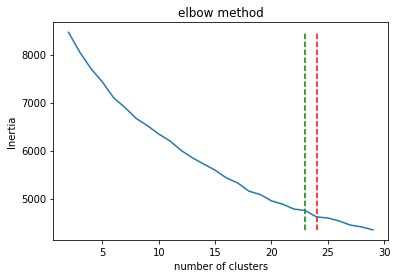

In [ ]:
plt.plot(range(2, 30), inertia_arr)
plt.vlines(23, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyle='--', colors = 'g')
plt.vlines(24, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyle='--', colors = 'r')

plt.title("elbow method")
plt.xlabel("number of clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# 손실 함수
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

def RMSLE(X_train, X_Valid, Y_train, Y_valid):
  k_rmsle_list=[]

  for k in range(2, 50):
    kmeans = KMeans(n_clusters = k, random_state=42)  #중심 초기화를 위한 난수 생성을 결정합니다. int를 사용하여 랜덤성을 결정론적으로 만듭니다. 용어집을 참조하십시오.
    kmeans.fit(X_train)

    clusters_train = kmeans.predict(X_train)
    clusters_train_df = pd.DataFrame(clusters_train, columns=['clusters'])
    X_train_k = pd.concat([X_train, clusters_train_df], axis=1)
    
    clusters_valid = kmeans.predict(X_Valid)
    clusters_valid_df = pd.DataFrame(clusters_valid, columns=['clusters'])
    X_valid_k = pd.concat([X_valid, clusters_valid_df], axis=1)

    y_log_train = np.log(Y_train)
    y_log_valid = np.log(Y_valid)

    rf = RandomForestRegressor(random_state = 42)
    rf.fit(X_train_k, y_log_train)
    y_pred = rf.predict(X_valid_k)

    print('k :', k)
    print('R2 : {:.3f}'.format(r2_score(y_log_valid, y_pred)))
    print('RF RMSLE : {:.6f}\n'.format(np.sqrt(mean_squared_log_error(y_log_valid, y_pred))))
    rmsle = np.sqrt(mean_squared_log_error(y_log_valid, y_pred))
    k_rmsle = [k, rmsle]
    k_rmsle_list.append(k_rmsle)

  k_df = pd.DataFrame(k_rmsle_list, columns=['k', 'RMSLE'])

RMSLE(X_train, X_valid, Y_train, Y_valid)

In [ ]:
from sklearn.metrics import silhouette_score
def silhouette_(random_state, X_train):
  k_range = range(2, 30)
  best_n = -1
  best_silhouette_score = -1

  for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state=random_state)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)

    score = silhouette_score(X_train, clusters)
    print('k :', k, 'score :', score)

    if score > best_silhouette_score :
      best_n = k
      best_silhouette_score = score

  print('best n : ', best_n, 'best score : ', best_silhouette_score)

silhouette_(42, ftr_vect)

k : 2 score : 0.0720637900974417
k : 3 score : 0.07929023497575372
k : 4 score : 0.0881246606719483
k : 5 score : 0.10162126249828722
k : 6 score : 0.10617711235036237
k : 7 score : 0.1157320566548804
k : 8 score : 0.11950685712684761
k : 9 score : 0.13322032168611808
k : 10 score : 0.13390057471228686
k : 11 score : 0.1428952639313192
k : 12 score : 0.14919359987610104
k : 13 score : 0.14936290647686956
k : 14 score : 0.1543966675762057
k : 15 score : 0.15688366238375592
k : 16 score : 0.15771084599026627
k : 17 score : 0.16258203491170625
k : 18 score : 0.16897769033107865
k : 19 score : 0.1689888572749153
k : 20 score : 0.17199942053394018
k : 21 score : 0.17658514129363811
k : 22 score : 0.17714713262245615
k : 23 score : 0.17503054545474708
k : 24 score : 0.17213672471854458
k : 25 score : 0.1828796466011969
k : 26 score : 0.18052028903417877
k : 27 score : 0.18247068782670756
k : 28 score : 0.17775326773727873
k : 29 score : 0.18983822891183863
best n :  29 best score :  0.189838